In [1]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

### file hierarchy and database connection vars

In [2]:
# directory & file hierarchy
iterationName = 'e1'
exp_path = 'museumdraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['E1c']
coll2 = db['E1d']

In [4]:
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['E1c']
coll2 = db['E1d']

### Preprocessing data and rendering images

Notes:

The collection that contains the data we will analyze for VSS is called 'E1c'. There were 16 categories in this set. 

12/19/17: We expanded the set of classes from 16 classes to 22 classes. These are saved under the experiment name 'E1d.'

There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [13]:
# wave 1 of data collection (16 classes)
experiment_name = 'E1c'
time_threshold = 1510252452134 ## this is the timepoint after which real data started getting collected
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
practice_categories = ['circle','triangle']
print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), experiment_name)

# wave 2 of data collection (22 classes) 
experiment_name = 'E1d'
valid_sessions += coll2.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
print 'We currently have {} valid sessions, including {}.'.format(len(valid_sessions), experiment_name)

We currently have 56 valid sessions from E1c.
We currently have 79 valid sessions, including E1d.


In [45]:
really_run_this = 1
if really_run_this:
    ## img writing parameters
    imsize = 224
    
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    age = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    draw_duration = []
    filename = []
    for s in valid_sessions:
        if s.split('_')[0]!='stationPilot0': ## ignore if data comes from station pilot
            print 'Analyzing {}'.format(s)
            if s.split('_')[0]=='E1c':
                this_collection = coll
            elif s.split('_')[0]=='E1d':
                this_collection = coll2
            image_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
            for imrec in image_recs:                                                            
                if imrec['category'] not in practice_categories: ## don't save practice category trials
                    stroke_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, 
                                                      {'sessionId':s}, 
                                                      {'dataType':'stroke'},
                                                      {'trialNum': imrec['trialNum']}]}).sort('time')   
                    
                    if 'age' in imrec.keys():
                        if imrec['age']:
                            if stroke_recs.count() > 0: ## only include trials if the drawings are not blank            
                                session_id.append(imrec['sessionId'])        
                                trial_num.append(imrec['trialNum']) 
                                category.append(imrec['category'])
                                age.append(imrec['age'])
                                png.append(imrec['imgData'])
                                submit_time.append(imrec['time'])
                                submit_date.append(imrec['date'])
                                filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId'])))
                                num_strokes.append(stroke_recs.count())
                                _svg = [] # this keeps track of the strokes from THIS final image
                                _svg_times = []
                                for strec in stroke_recs:
                                    _svg.append(strec['svg'])
                                    _svg_times.append(strec['time'])
                                draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                                svg.append(_svg)
                                svg_times.append(_svg_times)

                                ## and write out image data here too
                                imgData = imrec['imgData'];
                                filestr = base64.b64decode(imgData)
                                category_dir = os.path.join(sketch_dir,imrec['category'])
                                if not os.path.exists(category_dir):
                                    os.makedirs(category_dir)
                                fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId']))
                                with open(fname, "wb") as fh:
                                    fh.write(imgData.decode('base64'))  
                        

Analyzing E1c_1510252568116
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/foot
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/phone
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/chair
Analyzing E1c_1510253415559
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/train
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/car
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/rabbit
Analyzing E1c_1510253748384
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/boat
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/banana
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/ice cream
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/flower
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/train
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/chair
Analyzing E1c_1510254933095
/Users/judithfan/kiddraw/analysis/museumdraw/python/sketches/banana
/Users/judith

In [46]:
if really_run_this:
    X = pd.DataFrame([session_id,trial_num,category,age,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename])
    X = X.transpose()
    X.columns = ['session_id','trial_num','category','age','submit_time','submit_date','num_strokes','svg','svg_times','png','draw_duration', 'filename']

In [47]:
def get_bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

merged_experiment_name = 'E1cd'

if really_run_this:

    ## add mean pixel intensity (amount of ink spilled) & bounding box coords 
    mean_intensity = []
    bounding_box = []
    imsize = 100
    numpix = imsize**2
    thresh = 250
    for i,_d in X.iterrows():
        imgData = _d['png']
        filestr = base64.b64decode(imgData)
        fname = os.path.join('sketch.png')
        with open(fname, "wb") as fh:
            fh.write(imgData.decode('base64'))
        im = Image.open(fname).resize((imsize,imsize))
        _im = np.array(im)
        mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)
        # bounding box part
        rmin, rmax, cmin, cmax = get_bounding_box(np.array(Image.open(fname)))
        bounding_box.append(tuple((rmin, rmax, cmin, cmax)))

    ## add to dataframe    
    X = X.assign(mean_intensity=pd.Series(mean_intensity).values)
    X = X.assign(bounding_box=pd.Series(bounding_box).values)
    
    # save out csv
    if not os.path.exists('../preprocessed_data'):
        os.makedirs('../preprocessed_data')
    X.to_csv('../preprocessed_data/museumdraw_{}_data.csv'.format(merged_experiment_name))


In [48]:
X.shape

(408, 14)

### load drawing metadata csv back in

In [49]:
data_path = '../preprocessed_data/museumdraw_E1cd_data.csv'
X = pd.read_csv(data_path)

### Basic visualizations

Text(0.5,0,u'number of strokes')

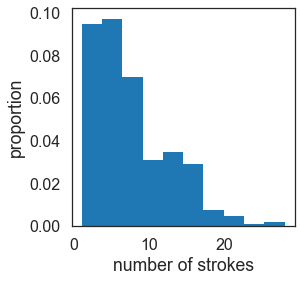

In [50]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.num_strokes.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('number of strokes')

Text(0.5,0,u'draw duration')

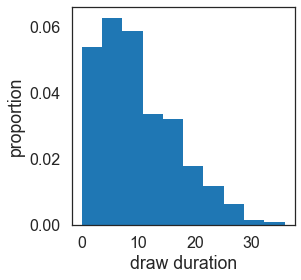

In [51]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.draw_duration.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('draw duration')

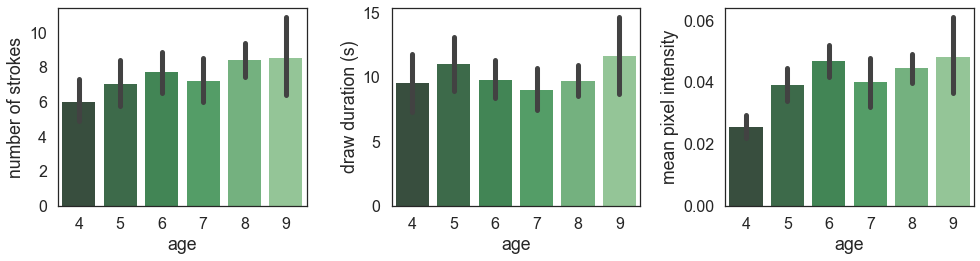

In [52]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='num_strokes',order=seq,palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='age',y='draw_duration',order=seq, palette="Greens_d")
plt.ylabel('draw duration (s)')

plt.subplot(1,3,3)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
plt.ylabel('mean pixel intensity')

plt.tight_layout()

In [54]:
# categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
# num_ims = 0
# ims_per_cat = []
# for c in categories:
#     num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
#     ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
# print num_ims

408
